In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
#import lightgbm as lgb
import gc
import sys
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
                # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)     
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
#1- Cargo fichero bureau_balance.csv y veo cabecera 
BureauBalance = pd.read_csv('/Users/LENOVO/Downloads/bureau_balance.csv', delimiter= ',' , header=0)
#BureauBalance.head()
BureauBalance
#BureauBalanceSNA.describe()
#BureauBalanceSNA = BureauBalance.dropna()
#BureauBalanceSNA


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [4]:
BureauBalance.dtypes.value_counts()

int64     2
object    1
dtype: int64

In [5]:
#Función cuenta variables categoricas
def count_categoricas(df, group_var, df_name):
    """Calcula conteos y conteos normalizados para cada observación
    de `group_var` de cada categoría única en cada variable categórica
    
    Parámetros
    --------
    df : dataframe 
         El marco de datos para calcular el valor cuenta.
        
    group_var : string
        La variable por la cual agrupar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
        Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con recuentos y recuentos normalizados de cada categoría única en cada variable categórica
        con una fila por cada valor único de `group_var`
        
    """
    
    #Seleccion de las columnas categóricas
    categorica = pd.get_dummies(df.select_dtypes('object'))

    # Pone la de identificación en la columna
    categorica[group_var] = df[group_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorica = categorica.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    
    # Itera a través de las columnas en el nivel 0
    for var in categorica.columns.levels[0]:
        # Iterar a través de las estadísticas en el nivel 1
        for stat in ['count', 'count_norm']:
            # Genera un nuevo nombre de columna
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorica.columns = column_names
    
    return categorica

In [6]:
#Función cuenta variables numéricas
def agg_numericas(df, group_var, df_name):
    """Agrega los valores numéricos en un marco de datos. Esto puede
    se utilizará para crear características para cada instancia de la variable de agrupación.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos para calcular las estadísticas
        group_var (string): 
            la variable por la cual agrupar df
        df_name (string):            
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas para
            Todas las columnas numéricas. Cada instancia de la variable de agrupación tendrá
            las estadísticas (media, min, max, suma; actualmente admitidas) calculadas.
            Las columnas también se renombran para realizar un seguimiento de las características creadas.
    
    """
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

   #Crea nuevos nombres de columna
    columns = [group_var]

   #Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        # Salta la variable de agrupación
        if var != group_var:
            #Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1][:-1]:
                # Hace un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [7]:
#Recuento de cada tipo de estado de las variables CATEGORICAS para cada préstamo anterior por campo 'SK_ID_BUREAU'
BureauBalance_counts = count_categoricas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_counts.head()
#BureauBalance_counts.describe()
BureauBalance_counts


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6842884,9,0.187500,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833
6842885,12,0.500000,0,0.000000,0,0.0,0,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000
6842886,8,0.242424,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000


In [8]:
# Calculo estadísticas de recuento de variables NUMERICAS para cada 'SK_ID_BUREAU' 
BureauBalance_agg = agg_numericas(BureauBalance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#BureauBalance_agg.head()
#BureauBalance_agg.describe()
BureauBalance_agg


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231
...,...,...,...,...,...,...
817390,6842884,48,-23.5,0,-47,-1128
817391,6842885,24,-11.5,0,-23,-276
817392,6842886,33,-16.0,0,-32,-528
817393,6842887,37,-18.0,0,-36,-666


In [9]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
BureauBalance_by_loan = BureauBalance_agg.merge(BureauBalance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
#BureauBalance_by_loan.head()
#BureauBalance_by_loan.describe()
BureauBalance_by_loan

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.000000,...,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.000000,...,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.000000,...,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.000000,...,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.000000,...,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,48,-23.5,0,-47,-1128,9,0.187500,0,0.000000,...,0,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833
817391,6842885,24,-11.5,0,-23,-276,12,0.500000,0,0.000000,...,0,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000
817392,6842886,33,-16.0,0,-32,-528,8,0.242424,0,0.000000,...,0,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000
817393,6842887,37,-18.0,0,-36,-666,6,0.162162,0,0.000000,...,0,0.0,0,0.0,0,0.0,31,0.837838,0,0.000000


In [10]:
#2- Cargo fichero bureau.csv
Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
Bureau.head()
#Bureau.describe()
#BureauSNA = Bureau.dropna()
#BureauSNA

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [11]:
# Fusion para incluir la SK_ID_CURR
BureauBalance_by_loanMerge = BureauBalance_by_loan.merge(Bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
BureauBalance_by_loanMerge
#BureauBalance_by_loanMerge.head()


,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.000000,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.000000,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.000000,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.000000,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.000000,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,48,-23.5,0,-47,-1128,9,0.187500,0,0.000000,...,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833,387020.0
817391,6842885,24,-11.5,0,-23,-276,12,0.500000,0,0.000000,...,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000,387020.0
817392,6842886,33,-16.0,0,-32,-528,8,0.242424,0,0.000000,...,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000,387020.0
817393,6842887,37,-18.0,0,-36,-666,6,0.162162,0,0.000000,...,0.0,0,0.0,0,0.0,31,0.837838,0,0.000000,387020.0


In [12]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_BUREAU'. Para unir a train****
BureauBalance_by_client = agg_numericas(BureauBalance_by_loanMerge.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
#BureauBalance_by_client.head()
#BureauBalance_by_client.describe()
BureauBalance_by_client

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.000000,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.000000,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.000000,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.000000,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.000000,1.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134537,456247.0,11,29.090909,82,10,320,11,-19.863636,-4.5,-53.0,...,11,3.181818,5,0,35.0,11,0.168838,0.500000,0.000000,1.857222
134538,456250.0,3,29.000000,33,26,87,3,-14.000000,-12.5,-16.0,...,3,16.666667,26,0,50.0,3,0.617216,0.928571,0.000000,1.851648
134539,456253.0,4,29.250000,31,24,117,4,-14.125000,-11.5,-15.0,...,4,3.250000,13,0,13.0,4,0.135417,0.541667,0.000000,0.541667
134540,456254.0,1,37.000000,37,37,37,1,-18.000000,-18.0,-18.0,...,1,0.000000,0,0,0.0,1,0.000000,0.000000,0.000000,0.000000


In [13]:
BureauBalance_by_client.dtypes.value_counts()

float64    53
int64      33
uint8      20
dtype: int64

In [14]:
# Missing values statistics
missing_values = missing_values_table(BureauBalance_by_client)
missing_values.head(20)

Your selected dataframe has 106 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [15]:
corrs = BureauBalance_by_client.corr()
corrs

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
SK_ID_CURR,1.000000,0.000975,-0.001733,-0.001046,-0.002811,0.000626,0.000975,-0.000055,0.003629,-0.001809,...,0.000975,-0.002606,-0.001899,-0.003303,-0.001057,0.000975,-0.000008,0.001840,-0.003284,0.002212
client_bureau_balance_MONTHS_BALANCE_count_count,0.000975,1.000000,0.070325,0.392171,-0.327461,0.821351,1.000000,-0.139772,0.334438,-0.459124,...,1.000000,0.028472,0.343325,-0.172180,0.482062,1.000000,0.019673,0.396362,-0.222902,0.585390
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.001733,0.070325,1.000000,0.813358,0.691403,0.476636,0.070325,-0.578908,-0.530041,-0.281760,...,0.070325,0.406689,0.407166,0.212757,0.305180,0.070325,0.027149,0.098923,-0.026627,0.055046
client_bureau_balance_MONTHS_BALANCE_count_max,-0.001046,0.392171,0.813358,1.000000,0.256337,0.678852,0.392171,-0.481980,-0.149860,-0.461826,...,0.392171,0.346610,0.525344,0.034088,0.436244,0.392171,0.052424,0.291956,-0.154080,0.262878
client_bureau_balance_MONTHS_BALANCE_count_min,-0.002811,-0.327461,0.691403,0.256337,1.000000,-0.063777,-0.327461,-0.430973,-0.824767,0.000418,...,-0.327461,0.272280,0.051320,0.372043,-0.030812,-0.327461,-0.004774,-0.175870,0.153832,-0.195401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_bureau_balance_STATUS_X_count_norm_count,0.000975,1.000000,0.070325,0.392171,-0.327461,0.821351,1.000000,-0.139772,0.334438,-0.459124,...,1.000000,0.028472,0.343325,-0.172180,0.482062,1.000000,0.019673,0.396362,-0.222902,0.585390
client_bureau_balance_STATUS_X_count_norm_mean,-0.000008,0.019673,0.027149,0.052424,-0.004774,0.025353,0.019673,0.034863,0.047496,0.004601,...,0.019673,0.751651,0.543465,0.483958,0.524941,0.019673,1.000000,0.739218,0.665290,0.621892
client_bureau_balance_STATUS_X_count_norm_max,0.001840,0.396362,0.098923,0.291956,-0.175870,0.372866,0.396362,-0.011891,0.215663,-0.177603,...,0.396362,0.574916,0.710499,0.161354,0.591811,0.396362,0.739218,1.000000,0.216897,0.684082
client_bureau_balance_STATUS_X_count_norm_min,-0.003284,-0.222902,-0.026627,-0.154080,0.153832,-0.194592,-0.222902,0.057863,-0.123547,0.154516,...,-0.222902,0.482830,0.120335,0.728770,0.071669,-0.222902,0.665290,0.216897,1.000000,0.103000


In [16]:
corrs = corrs.sort_values('client_bureau_balance_MONTHS_BALANCE_count_mean', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_bureau_balance_MONTHS_BALANCE_count_mean'].head(10))

,client_bureau_balance_MONTHS_BALANCE_count_mean
client_bureau_balance_MONTHS_BALANCE_count_mean,1.000000
client_bureau_balance_MONTHS_BALANCE_count_max,0.813358
client_bureau_balance_STATUS_C_count_mean,0.757616
client_bureau_balance_MONTHS_BALANCE_count_min,0.691403
client_bureau_balance_STATUS_C_count_max,0.663575
client_bureau_balance_MONTHS_BALANCE_count_sum,0.476636
client_bureau_balance_STATUS_C_count_sum,0.463586
client_bureau_balance_STATUS_C_count_norm_mean,0.455154
client_bureau_balance_STATUS_C_count_min,0.435266
client_bureau_balance_STATUS_X_count_max,0.407166


In [17]:
#2- Cargo fichero bureau.csv
#Bureau = pd.read_csv('/Users/LENOVO/Downloads/bureau.csv', delimiter= ',' , header=0)
#BureauSNA = Bureau.dropna()
#BureauSNA
Bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [18]:
#Se cuentan los prestamos anteriores por campo SK_ID_BUREAU y se agrupan por 'SK_ID_CURR'
Previous_loan_counts = Bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
Previous_loan_counts

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


In [19]:
#Genera recuento y estadisticas de las variables para cada préstamo anterior eliminando columna 'SK_ID_BUREAU'y
#agrupando por campo 'SK_ID_CURR'
Bureau_agg = Bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR',
as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index() 
#Bureau_agg.head()
Bureau_agg

SK_ID_CURR DAYS_CREDIT                                  \
                        count         mean   max   min    sum   
0          100001           7  -735.000000   -49 -1572  -5145   
1          100002           8  -874.000000  -103 -1437  -6992   
2          100003           4 -1400.750000  -606 -2586  -5603   
3          100004           2  -867.000000  -408 -1326  -1734   
4          100005           3  -190.666667   -62  -373   -572   
...           ...         ...          ...   ...   ...    ...   
305806     456249          13 -1667.076923  -483 -2713 -21672   
305807     456250           3  -862.000000  -760 -1002  -2586   
305808     456253           4  -867.500000  -713  -919  -3470   
305809     456254           1 -1104.000000 -1104 -1104  -1104   
305810     456255          11 -1089.454545  -363 -2337 -11984   

       CREDIT_DAY_OVERDUE               ... DAYS_CREDIT_UPDATE               \
                    count mean max min  ...              count         mean   
0                       7  0.0   0   0  ...                  7   -93.142857   
1                       8  0.0   0   0  ...                  8  -499.875000   
2                       4  0.0   0   0  ...                  4  -816.000000   
3                       2  0.0   0   0  ...                  2  -532.000000   
4                       3  0.0   0   0  ...                  3   -54.333333   
...                   ...  ...  ..  ..  ...                ...          ...   
305806                 13  0.0   0   0  ...                 13 -1064.538462   
305807                  3  0.0   0   0  ...                  3   -60.333333   
305808                  4  0.0   0   0  ...                  4  -253.250000   
305809                  1  0.0   0   0  ...                  1  -401.000000   
305810                 11  0.0   0   0  ...                 11  -531.090909   

                         AMT_ANNUITY                                      \
        max   min    sum       count           mean       max        min   
0        -6  -155   -652           7    3545.357143   10822.5      0.000   
1        -7 -1185  -3999           7       0.000000       0.0      0.000   
2       -43 -2131  -3264           0            NaN       NaN        NaN   
3      -382  -682  -1064           0            NaN       NaN        NaN   
4       -11  -121   -163           3    1420.500000    4261.5      0.000   
...     ...   ...    ...         ...            ...       ...        ...   
305806  -12 -2498 -13839           0            NaN       NaN        NaN   
305807  -23  -127   -181           3  154567.965000  384147.0  27757.395   
305808   -5  -701  -1013           3   58369.500000   58369.5  58369.500   
305809 -401  -401   -401           1       0.000000       0.0      0.000   
305810   -8 -1621  -5842           9    1081.500000    3244.5      0.000   

                    
               sum  
0        24817.500  
1            0.000  
2            0.000  
3            0.000  
4         4261.500  
...            ...  
305806       0.000  
305807  463703.895  
305808  175108.500  
305809       0.000  
305810    9733.500  

[305811 rows x 61 columns]

In [20]:
#Funcion para cambiar nombres en el df
# Lista de nombres de columna
columns = ['SK_ID_CURR']

#Itera a través de los nombres de las variables
for var in Bureau_agg.columns.levels[0]:
    # Salta el nombre de identificación
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in Bureau_agg.columns.levels[1][:-1]:
            # Itera a través de los nombres de estadísticas
            columns.append('bureau_%s_%s' % (var, stat))

In [21]:
#**** Asigna la lista de nombres de columnas como los nombres de columna del marco de datos***
Bureau_agg.columns = columns
#dfBureau_agg.head()
Bureau_agg

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.000,24817.500
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.000,0.000
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.000
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.000
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.000,4261.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,13,-1667.076923,-483,-2713,-21672,13,0.0,0,0,...,13,-1064.538462,-12,-2498,-13839,0,NaN,NaN,NaN,0.000
305807,456250,3,-862.000000,-760,-1002,-2586,3,0.0,0,0,...,3,-60.333333,-23,-127,-181,3,154567.965000,384147.0,27757.395,463703.895
305808,456253,4,-867.500000,-713,-919,-3470,4,0.0,0,0,...,4,-253.250000,-5,-701,-1013,3,58369.500000,58369.5,58369.500,175108.500
305809,456254,1,-1104.000000,-1104,-1104,-1104,1,0.0,0,0,...,1,-401.000000,-401,-401,-401,1,0.000000,0.0,0.000,0.000


In [22]:
categorical = pd.get_dummies(Bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = Bureau['SK_ID_CURR']
#categorical.head()
categorical

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,259355
1716424,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100044
1716425,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100044
1716426,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,246829


In [23]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [24]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [25]:
# Dataframe agrupando Bureau_agg con categorical_grouped por préstamo anterior
BureauAgregado_by_loan = categorical_grouped.merge(Bureau_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
#BureauAgregado_by_loan.head()
#BureauAgregado_by_loan.describe()
BureauAgregado_by_loan

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
100001.0,3.0,0.428571,0.0,0.0,4.0,0.571429,0.0,0.0,7.0,1.0,...,6.0,-736.000000,-26.0,-2425.0,-4416.0,5.0,53336.700000,161203.5,16380.0,266683.5
100002.0,2.0,0.250000,0.0,0.0,6.0,0.750000,0.0,0.0,8.0,1.0,...,1.0,-1074.000000,-1074.0,-1074.0,-1074.0,0.0,NaN,NaN,NaN,0.0
100003.0,1.0,0.250000,0.0,0.0,3.0,0.750000,0.0,0.0,4.0,1.0,...,8.0,-789.500000,-12.0,-1805.0,-6316.0,0.0,NaN,NaN,NaN,0.0
100004.0,0.0,0.000000,0.0,0.0,2.0,1.000000,0.0,0.0,2.0,1.0,...,4.0,-193.000000,-8.0,-413.0,-772.0,0.0,NaN,NaN,NaN,0.0
100005.0,2.0,0.666667,0.0,0.0,1.0,0.333333,0.0,0.0,3.0,1.0,...,11.0,-535.454545,-4.0,-2125.0,-5890.0,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,-560.600000,-29.0,-898.0,-2803.0,0.0,NaN,NaN,NaN,0.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,-430.666667,-5.0,-1201.0,-2584.0,5.0,33684.300000,44140.5,18000.0,168421.5
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,-626.000000,-3.0,-1651.0,-7512.0,7.0,16089.942857,29217.6,0.0,112629.6
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,-727.666667,-117.0,-1301.0,-2183.0,0.0,NaN,NaN,NaN,0.0


In [26]:
# Missing values statistics
missing_values = missing_values_table(BureauAgregado_by_loan)
missing_values.head(20)

Your selected dataframe has 107 columns.
There are 106 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,316609,72.8
bureau_AMT_ANNUITY_max,316609,72.8
bureau_AMT_ANNUITY_mean,316609,72.8
bureau_AMT_CREDIT_MAX_OVERDUE_max,221862,51.0
bureau_AMT_CREDIT_MAX_OVERDUE_mean,221862,51.0
bureau_AMT_CREDIT_MAX_OVERDUE_min,221862,51.0
bureau_DAYS_ENDDATE_FACT_mean,166678,38.3
bureau_DAYS_ENDDATE_FACT_max,166678,38.3
bureau_DAYS_ENDDATE_FACT_min,166678,38.3
bureau_AMT_CREDIT_SUM_LIMIT_mean,154330,35.5


In [27]:
corrs = BureauAgregado_by_loan.corr()
corrs

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
CREDIT_ACTIVE_Active_count,1.000000,0.382554,0.006320,-0.000833,0.367205,-0.379412,0.056124,-0.022761,0.690793,0.004473,...,-0.002205,-0.002612,0.000432,-0.002296,-0.000961,0.001373,0.003331,0.003674,0.001214,0.002514
CREDIT_ACTIVE_Active_count_norm,0.382554,1.000000,-0.001447,-0.002777,-0.425554,-0.992557,-0.050400,-0.053121,-0.176435,0.014569,...,-0.000338,0.000176,0.001035,-0.000109,0.001222,0.005582,0.003107,0.002904,0.002361,0.001926
CREDIT_ACTIVE_Bad debt_count,0.006320,-0.001447,1.000000,0.691803,0.000907,-0.004528,0.011345,0.005268,0.005369,-0.001431,...,-0.000770,0.000777,0.000868,0.000326,-0.000097,-0.002353,-0.000410,-0.000163,-0.000330,-0.000332
CREDIT_ACTIVE_Bad debt_count_norm,-0.000833,-0.002777,0.691803,1.000000,-0.002369,-0.005180,0.004275,0.002021,-0.000744,0.000004,...,0.000869,-0.000088,0.000021,-0.000068,-0.001660,-0.002795,-0.000453,-0.000210,-0.000281,-0.000359
CREDIT_ACTIVE_Closed_count,0.367205,-0.425554,0.000907,-0.002369,1.000000,0.427657,0.071885,-0.020475,0.925152,-0.005474,...,0.000182,0.000284,0.001572,-0.000027,-0.001508,-0.003052,0.002999,0.002837,-0.000870,0.001799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bureau_AMT_ANNUITY_count,0.001373,0.005582,-0.002353,-0.002795,-0.003052,-0.005551,-0.000252,-0.000130,-0.001759,0.001153,...,0.470427,-0.006700,0.138728,-0.120946,-0.309534,1.000000,0.000833,0.037939,-0.040567,0.103230
bureau_AMT_ANNUITY_mean,0.003331,0.003107,-0.000410,-0.000453,0.002999,-0.003004,-0.001452,-0.000799,0.003629,0.001011,...,0.001408,0.015495,0.012669,0.007253,0.005442,0.000833,1.000000,0.699495,0.580304,0.722334
bureau_AMT_ANNUITY_max,0.003674,0.002904,-0.000163,-0.000210,0.002837,-0.002771,-0.001568,-0.001042,0.003639,0.000791,...,0.035918,0.001647,0.013415,-0.012757,-0.024457,0.037939,0.699495,1.000000,0.135657,0.958153
bureau_AMT_ANNUITY_min,0.001214,0.002361,-0.000330,-0.000281,-0.000870,-0.002286,-0.000706,-0.000580,-0.000199,0.001044,...,-0.040677,0.022405,-0.005230,0.030545,0.035285,-0.040567,0.580304,0.135657,1.000000,0.145047


In [28]:
corrs = corrs.sort_values('CREDIT_ACTIVE_Closed_count_norm', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['CREDIT_ACTIVE_Closed_count_norm'].head(10))

,CREDIT_ACTIVE_Closed_count_norm
CREDIT_ACTIVE_Closed_count_norm,1.000000
CREDIT_ACTIVE_Closed_count,0.427657
CREDIT_TYPE_Consumer credit_count_norm,0.413929
CREDIT_TYPE_Consumer credit_count,0.266012
CREDIT_CURRENCY_currency 1_count,0.176263
CREDIT_TYPE_Car loan_count,0.026558
CREDIT_TYPE_Microloan_count,0.020777
CREDIT_TYPE_Loan for business development_count,0.017420
CREDIT_TYPE_Unknown type of loan_count,0.014563
CREDIT_CURRENCY_currency 2_count,0.014457


In [29]:
def agg_numeric(df, parent_var, df_name):
    """
    Agrupa y agrega los valores numéricos en un marco de datos hijo
    por la variable padre.
    
    Parameters
    --------
        df (dataframe): 
            el marco de datos hijo para calcular las estadísticas en
        parent_var (string): 
            La variable principal utilizada para agrupar y agregar
        df_name (string): 
            la variable utilizada para renombrar las columnas
        
    Return
    --------
        agg (dataframe): 
            un marco de datos con las estadísticas agregadas por el `parent_var` para
            Todas las columnas numéricas. Cada observación de la variable principal tendrá
            una fila en el marco de datos con la variable principal como índice.
            Las columnas también se renombran usando el `df_name`. Columnas con todos los duplicados.
            Se eliminan los valores.
    
    """
      
    # Elimina variables de identificación que no sean variables de agrupación
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Solo toma las variables numéricas
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    
    # Agrupa por la variable especificada y calcula las estadísticas
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Necesita crear nuevos nombres de columna
    columns = []

    # Itera a través de los nombres de las variables
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Itera a través de los nombres de estadísticas
            for stat in agg.columns.levels[1]:
                # Genera un nuevo nombre de columna para la variable y estadística
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Elimina las columnas con todos los valores redundantes
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [30]:
def agg_categorical(df, parent_var, df_name):
    """
    Agrega las características categóricas en un marco de datos hijo
    para cada observación de la variable principal.
    
    Parameters
    --------
    df : dataframe 
        El marco de datos para calcular el valor cuenta.
        
    parent_var : string
        La variable por la cual agrupar y agregar el marco de datos. Para cada unico
        valor de esta variable, el marco de datos final tendrá una fila
        
    df_name : string
       Variable agregada al frente de los nombres de columna para realizar un seguimiento de las columnas

    
    Return
    --------
    categorical : dataframe
        Un marco de datos con estadísticas agregadas para cada observación de parent_var
        Las columnas también se renombran y las columnas con valores duplicados se eliminan.
        
    """
       
    # Selecciona las columnas categóricas
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Asegura poner la identificación de identificación en la columna
    categorical[parent_var] = df[parent_var]

    # Agrupa por el grupo var y calcula la suma y la media
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterar a través de las columnas en el nivel 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Iterar a través de las estadísticas en el nivel 1
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
        
    # Elimina columnas duplicadas por valores
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [31]:
def aggregate_client(df, group_vars, df_names):
    """Agregar un marco de datos con datos a nivel de préstamo
    a nivel del cliente
    
    Args:
        df (dataframe): datos a nivel de préstamo
        group_vars (lista de dos cadenas): agrupando variables para el préstamo
        y luego el cliente (ejemplo ['SK_ID_PREV', 'SK_ID_CURR'])
        nombres (lista de dos cadenas): nombres para llamar a las columnas resultantes
        (ejemplo ['efectivo', 'cliente'])
        
    Returns:
        df_client (dataframe): estadísticas numéricas agregadas a nivel del cliente.
       Cada cliente tendrá una sola fila con todos los datos numéricos agregados
    """
    
    # Agrega las columnas numéricas
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # Si hay variables categóricas
    if any(df.dtypes == 'category'):
    
        # Cuenta las columnas categóricas
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Fusiona la numérica y categórica
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No hay variables categóricas
    else:
        # Combina para obtener la identificación del cliente en el marco de datos
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Elimina la identificación del préstamo
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
                
        # Agrega estadísticas numéricas por columna
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Gestión de la memoria
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [32]:
#3-Cargo fichero installments_payments.csv y veo cabecera
installments_payments = pd.read_csv('/Users/LENOVO/Downloads/installments_payments.csv', delimiter= ',' , header=0)
installments_payments.head()
installments_payments
#installments_paymentsSNA = installments_payments.dropna()
#installments_paymentsSNA

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [33]:
installments_payments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

In [34]:
##***** Agrega las estadísticas de prestamos por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
installments_payments_by_client = aggregate_client(installments_payments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
#installments_payments_by_client.head()
installments_payments_by_client

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,27746.775,27746.775,29250.900,29250.900,41195.925,41195.925,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4.394101e+06,4.394101e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,3.172190e+04,3.172190e+04,6.386540e+04,6.386540e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,43318.800,43318.800,56161.845,56161.845,56161.845,56161.845,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-7658.0,-5880.0,-1659.0,-1470.0,-1094.0,-840.0,-266.0,-210.0,-840.0,-1094.0,...,46241.370,46241.370,52450.470,52450.470,52450.470,52450.470,8.970507e+04,8.970507e+04,3.671533e+05,3.671533e+05
456252,-86178.0,-86076.0,-14820.0,-14796.0,-14363.0,-14346.0,-13962.0,-13896.0,-14346.0,-14363.0,...,60281.280,60281.280,60419.205,60419.205,60419.205,60419.205,6.044679e+04,6.044679e+04,3.625152e+05,3.625152e+05
456253,-160696.0,-159541.0,-34151.0,-34001.0,-33424.0,-33221.0,-32708.0,-32471.0,-13820.0,-13883.0,...,41805.990,61529.040,33413.760,33413.760,57622.815,61595.910,6.166174e+04,6.166174e+04,3.048921e+05,3.247575e+05


In [35]:
# Missing values statistics
missing_values = missing_values_table(installments_payments_by_client)
missing_values.head(20)

Your selected dataframe has 106 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
client_installments_DAYS_ENTRY_PAYMENT_min_min,9,0.0
client_installments_DAYS_ENTRY_PAYMENT_mean_min,9,0.0
client_installments_AMT_PAYMENT_max_mean,9,0.0
client_installments_AMT_PAYMENT_mean_max,9,0.0
client_installments_AMT_PAYMENT_mean_mean,9,0.0
client_installments_AMT_PAYMENT_max_min,9,0.0
client_installments_AMT_PAYMENT_mean_min,9,0.0
client_installments_AMT_PAYMENT_min_max,9,0.0
client_installments_AMT_PAYMENT_min_mean,9,0.0
client_installments_AMT_PAYMENT_min_min,9,0.0


In [36]:
corrs = installments_payments_by_client.corr()
corrs

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
client_installments_DAYS_ENTRY_PAYMENT_sum_sum,1.000000,0.999980,0.916762,0.917312,0.841427,0.842025,0.309388,0.308142,0.947233,0.947766,...,-0.151254,-0.189045,-0.263856,-0.287818,-0.315568,-0.330685,-0.432927,-0.431075,-0.630140,-0.636144
client_installments_DAYS_INSTALMENT_sum_sum,0.999980,1.000000,0.916758,0.917313,0.841438,0.842063,0.309329,0.308079,0.947512,0.947987,...,-0.150723,-0.188516,-0.263397,-0.287350,-0.315013,-0.330131,-0.432484,-0.430629,-0.629451,-0.635479
client_installments_DAYS_ENTRY_PAYMENT_min_sum,0.916762,0.916758,1.000000,0.999986,0.979183,0.979350,0.597999,0.596786,0.950952,0.951156,...,-0.292483,-0.379542,-0.350036,-0.383532,-0.458169,-0.484601,-0.505682,-0.504284,-0.643488,-0.652396
client_installments_DAYS_INSTALMENT_min_sum,0.917312,0.917313,0.999986,1.000000,0.978957,0.979142,0.597004,0.595814,0.951399,0.951591,...,-0.291298,-0.378290,-0.349465,-0.382975,-0.457239,-0.483665,-0.505375,-0.503965,-0.643336,-0.652258
client_installments_DAYS_ENTRY_PAYMENT_mean_sum,0.841427,0.841438,0.979183,0.978957,1.000000,0.999956,0.743118,0.742347,0.909273,0.909283,...,-0.337738,-0.438460,-0.355311,-0.389296,-0.487335,-0.516940,-0.495098,-0.493948,-0.603690,-0.613623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_installments_AMT_INSTALMENT_mean_sum,-0.330685,-0.330131,-0.484601,-0.483665,-0.516940,-0.515636,-0.478522,-0.474846,-0.352214,-0.352727,...,0.706691,0.831163,0.853791,0.888754,0.981802,1.000000,0.782777,0.785057,0.728307,0.725200
client_installments_AMT_INSTALMENT_max_sum,-0.432927,-0.432484,-0.505682,-0.505375,-0.495098,-0.494388,-0.315503,-0.312135,-0.430965,-0.431522,...,0.405728,0.457558,0.732150,0.739154,0.787598,0.782777,1.000000,0.999535,0.748150,0.731633
client_installments_AMT_PAYMENT_max_sum,-0.431075,-0.430629,-0.504284,-0.503965,-0.493948,-0.493227,-0.315464,-0.312089,-0.429243,-0.429802,...,0.408443,0.458952,0.739249,0.741814,0.792884,0.785057,0.999535,1.000000,0.749133,0.730949
client_installments_AMT_PAYMENT_sum_sum,-0.630140,-0.629451,-0.643488,-0.643336,-0.603690,-0.603034,-0.309508,-0.306315,-0.576926,-0.577870,...,0.382715,0.472049,0.696848,0.731701,0.716503,0.728307,0.748150,0.749133,1.000000,0.993556


In [37]:
corrs = corrs.sort_values('client_installments_DAYS_INSTALMENT_mean_sum', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_installments_DAYS_INSTALMENT_mean_sum'].head(10))

,client_installments_DAYS_INSTALMENT_mean_sum
client_installments_DAYS_INSTALMENT_mean_sum,1.000000
client_installments_DAYS_ENTRY_PAYMENT_mean_sum,0.999956
client_installments_DAYS_ENTRY_PAYMENT_min_sum,0.979350
client_installments_DAYS_INSTALMENT_min_sum,0.979142
client_installments_DAYS_INSTALMENT_sum_min,0.910070
client_installments_DAYS_ENTRY_PAYMENT_sum_min,0.910024
client_installments_DAYS_ENTRY_PAYMENT_sum_mean,0.844514
client_installments_DAYS_INSTALMENT_sum_mean,0.844446
client_installments_DAYS_INSTALMENT_sum_sum,0.842063
client_installments_DAYS_ENTRY_PAYMENT_sum_sum,0.842025


In [38]:
#4-Cargo fichero POS_CASH_balance.csv y veo cabecera
POS_CASH_balance = pd.read_csv('/Users/LENOVO/Downloads/POS_CASH_balance.csv', delimiter= ',' , header=0)
#POS_CASH_balance.head()
POS_CASH_balance
#POS_CASH_balanceSNA = POS_CASH_balance.dropna()
#POS_CASH_balanceSNA

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [39]:
POS_CASH_balance.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

In [40]:
##***** Agrega las estadísticas de cash por 'SK_ID_CURR'. Elimina columna 'SK_ID_PREV'****
POS_CASH_balance_by_client = aggregate_client(POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
#POS_CASH_balance_by_client.head()
POS_CASH_balance_by_client

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28,28.0,36.0,36.000,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,0,456.0,456.0,456.000,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,0,288.0,248.0,283.000,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,0,16.0,12.0,15.000,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,0,132.0,99.0,128.700,132.0,110,110,121,792.0,1287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-405,-81,-45.0,-9,-45,-45.000000,-45,-9,-5.0,-1,...,0,72.0,63.0,70.875,72.0,72,72,81,315.0,567.0
456252,-3871,-574,-553.0,-532,-553,-553.000000,-553,-82,-79.0,-76,...,0,42.0,42.0,42.000,42.0,49,49,49,147.0,294.0
456253,-7746,-1389,-1347.0,-1305,-549,-455.647059,-378,-96,-94.5,-93,...,30,74.0,114.0,114.000,114.0,101,101,101,219.0,630.0


In [41]:
# Missing values statistics
missing_values = missing_values_table(POS_CASH_balance_by_client)
missing_values.head(20)

Your selected dataframe has 94 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
client_cash_CNT_INSTALMENT_FUTURE_min_min,28,0.0
client_cash_CNT_INSTALMENT_FUTURE_min_mean,28,0.0
client_cash_CNT_INSTALMENT_FUTURE_max_max,28,0.0
client_cash_CNT_INSTALMENT_mean_max,28,0.0
client_cash_CNT_INSTALMENT_min_max,28,0.0
client_cash_CNT_INSTALMENT_max_mean,28,0.0
client_cash_CNT_INSTALMENT_mean_mean,28,0.0
client_cash_CNT_INSTALMENT_min_mean,28,0.0
client_cash_CNT_INSTALMENT_max_min,28,0.0
client_cash_CNT_INSTALMENT_mean_min,28,0.0


In [42]:
corrs = POS_CASH_balance_by_client.corr()
corrs

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
client_cash_MONTHS_BALANCE_sum_sum,1.000000,0.816148,0.706141,0.494765,0.853902,0.845985,0.303663,0.398424,0.315362,0.243863,...,-0.529431,-0.478788,-0.538178,-0.519099,-0.515196,-0.949696,-0.949693,-0.949736,-0.422007,-0.660097
client_cash_MONTHS_BALANCE_min_sum,0.816148,1.000000,0.981718,0.887852,0.820941,0.698969,0.171722,0.652383,0.606115,0.559995,...,-0.250578,-0.712784,-0.742422,-0.734686,-0.732278,-0.803184,-0.803179,-0.803244,-0.575510,-0.685084
client_cash_MONTHS_BALANCE_mean_sum,0.706141,0.981718,1.000000,0.959201,0.771945,0.627435,0.131046,0.699808,0.668821,0.634012,...,-0.156351,-0.682861,-0.700896,-0.698505,-0.697354,-0.675183,-0.675178,-0.675218,-0.530107,-0.599002
client_cash_MONTHS_BALANCE_max_sum,0.494765,0.887852,0.959201,1.000000,0.646722,0.478560,0.061738,0.722703,0.716515,0.700873,...,-0.005776,-0.592001,-0.591581,-0.597287,-0.598082,-0.439180,-0.439174,-0.439176,-0.426638,-0.430429
client_cash_MONTHS_BALANCE_sum_min,0.853902,0.820941,0.771945,0.646722,1.000000,0.936064,0.366346,0.700961,0.625207,0.551934,...,-0.362820,-0.458553,-0.506002,-0.488824,-0.485662,-0.761646,-0.761641,-0.761530,-0.385596,-0.557564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_cash_CNT_INSTALMENT_count_sum,-0.949696,-0.803184,-0.675183,-0.439180,-0.761646,-0.739002,-0.249708,-0.335837,-0.253763,-0.184187,...,0.478490,0.632348,0.690088,0.667964,0.662247,1.000000,0.999999,0.999874,0.576746,0.783709
client_cash_CNT_INSTALMENT_FUTURE_count_sum,-0.949693,-0.803179,-0.675178,-0.439174,-0.761641,-0.738995,-0.249701,-0.335833,-0.253759,-0.184184,...,0.478492,0.632348,0.690090,0.667964,0.662246,0.999999,1.000000,0.999873,0.576746,0.783710
client_cash_MONTHS_BALANCE_count_sum,-0.949736,-0.803244,-0.675218,-0.439176,-0.761530,-0.738801,-0.249410,-0.335646,-0.253582,-0.184017,...,0.478388,0.632329,0.690052,0.667931,0.662222,0.999874,0.999873,1.000000,0.576662,0.783579
client_cash_CNT_INSTALMENT_FUTURE_sum_sum,-0.422007,-0.575510,-0.530107,-0.426638,-0.385596,-0.283813,-0.032743,-0.257312,-0.232876,-0.208088,...,-0.005128,0.929669,0.917813,0.930984,0.926857,0.576746,0.576746,0.576662,1.000000,0.940446


In [43]:
corrs = corrs.sort_values('client_cash_CNT_INSTALMENT_min_sum', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_cash_CNT_INSTALMENT_min_sum'].head(10))

,client_cash_CNT_INSTALMENT_min_sum
client_cash_CNT_INSTALMENT_min_sum,1.000000
client_cash_CNT_INSTALMENT_mean_sum,0.970460
client_cash_CNT_INSTALMENT_max_sum,0.962861
client_cash_CNT_INSTALMENT_FUTURE_max_sum,0.960451
client_cash_CNT_INSTALMENT_FUTURE_sum_sum,0.917813
client_cash_CNT_INSTALMENT_FUTURE_mean_sum,0.915913
client_cash_CNT_INSTALMENT_sum_sum,0.904687
client_cash_CNT_INSTALMENT_sum_max,0.866830
client_cash_CNT_INSTALMENT_FUTURE_min_count,0.860696
client_cash_MONTHS_BALANCE_sum_count,0.860667


In [44]:
#5-Cargo fichero credit_card_balance.csv y veo cabecera
credit_card_balance = pd.read_csv('/Users/LENOVO/Downloads/credit_card_balance.csv', delimiter= ',' , header=0)
#credit_card_balance.head()
credit_card_balance
#credit_card_balanceSNA = credit_card_balance.dropna()
#credit_card_balanceSNA

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [45]:
credit_card_balance.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

In [46]:
##***** Agrega las estadísticas de credit_card_balance por 'SK_ID_CURR'.Elimina columna 'SK_ID_PREV'
credit_card_balance_by_client = aggregate_client(credit_card_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
#credit_card_balance_by_client.head()
credit_card_balance_by_client

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432432,4843.064189,4843.064189,4843.064189,55485.00,55485.00,55485.00,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346250,7168.346250,7168.346250,153675.00,153675.00,153675.00,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-35301,-1681,-861.0,-861,-861.0,-861,-41,-41,-41.0,-41,...,24475.609756,32720.544878,32720.544878,32720.544878,482329.62,482329.62,482329.62,279000.0,279000.0,279000.0
456246,-352,-72,-44.0,-44,-44.0,-44,-16,-9,-9.0,-9,...,0.000000,18778.275000,18778.275000,18778.275000,43669.71,43669.71,43669.71,0.0,0.0,0.0
456247,-442225,-9120,-4655.0,-4655,-4655.0,-4655,-190,-96,-96.0,-96,...,2136.315789,4883.755263,4883.755263,4883.755263,99990.00,99990.00,99990.00,96750.0,96750.0,96750.0


In [47]:
# Missing values statistics
missing_values = missing_values_table(credit_card_balance_by_client)
missing_values.head(20)

Your selected dataframe has 331 columns.
There are 63 columns that have missing values.


,Missing Values,% of Total Values
client_credit_AMT_PAYMENT_CURRENT_min_max,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_min_min,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_min_mean,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_max_mean,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_max_max,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_max_min,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_mean_max,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_mean_min,31438,30.4
client_credit_AMT_PAYMENT_CURRENT_mean_mean,31438,30.4
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean,31364,30.3


In [48]:
corrs = credit_card_balance_by_client.corr()
corrs

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
client_credit_MONTHS_BALANCE_sum_sum,1.000000,0.994032,0.993690,0.993630,0.993377,0.981052,0.749788,0.956832,0.956513,0.943258,...,0.313280,0.314113,0.314284,0.310853,0.166008,0.163702,0.165161,0.143942,0.142864,0.140984
client_credit_MONTHS_BALANCE_min_sum,0.994032,1.000000,0.999936,0.999864,0.999593,0.987328,0.770207,0.981399,0.981070,0.967778,...,0.325326,0.321534,0.321729,0.318186,0.149835,0.147403,0.148901,0.125413,0.124228,0.122316
client_credit_MONTHS_BALANCE_mean_sum,0.993690,0.999936,1.000000,0.999926,0.999652,0.987363,0.777345,0.982048,0.981716,0.968399,...,0.325731,0.321727,0.321923,0.318372,0.149011,0.146575,0.148076,0.124991,0.123803,0.121891
client_credit_MONTHS_BALANCE_sum_min,0.993630,0.999864,0.999926,1.000000,0.999831,0.988015,0.777211,0.982137,0.981901,0.969032,...,0.325885,0.321785,0.321950,0.318545,0.148996,0.146745,0.148147,0.124858,0.123761,0.121966
client_credit_MONTHS_BALANCE_sum_mean,0.993377,0.999593,0.999652,0.999831,1.000000,0.990322,0.776811,0.982031,0.982117,0.971340,...,0.326396,0.321791,0.321868,0.319034,0.148736,0.147070,0.148171,0.124328,0.123528,0.122118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
client_credit_AMT_PAYMENT_CURRENT_max_max,0.163702,0.147403,0.146575,0.146745,0.147070,0.146973,0.064590,0.098810,0.099092,0.098958,...,0.334987,0.639172,0.638419,0.640289,0.997084,1.000000,0.999065,0.501276,0.502454,0.502956
client_credit_AMT_PAYMENT_CURRENT_max_mean,0.165161,0.148901,0.148076,0.148147,0.148171,0.146036,0.065966,0.100141,0.100105,0.097824,...,0.334552,0.640110,0.639796,0.638742,0.998789,0.999065,1.000000,0.502659,0.503313,0.502953
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,0.143942,0.125413,0.124991,0.124858,0.124328,0.118693,0.071775,0.082180,0.081546,0.075519,...,0.609247,0.332625,0.332963,0.330439,0.503743,0.501276,0.502659,1.000000,0.999261,0.997616
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,0.142864,0.124228,0.123803,0.123761,0.123528,0.119974,0.070675,0.081017,0.080715,0.076971,...,0.609542,0.332424,0.332506,0.330930,0.503255,0.502454,0.503313,0.999261,1.000000,0.998936


In [49]:
corrs = corrs.sort_values('client_credit_MONTHS_BALANCE_min_sum', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['client_credit_MONTHS_BALANCE_min_sum'].head(10))

,client_credit_MONTHS_BALANCE_min_sum
client_credit_MONTHS_BALANCE_min_sum,1.000000
client_credit_MONTHS_BALANCE_mean_sum,0.999936
client_credit_MONTHS_BALANCE_sum_min,0.999864
client_credit_MONTHS_BALANCE_sum_mean,0.999593
client_credit_MONTHS_BALANCE_sum_sum,0.994032
client_credit_MONTHS_BALANCE_sum_max,0.987328
client_credit_MONTHS_BALANCE_min_min,0.981399
client_credit_MONTHS_BALANCE_min_mean,0.981070
client_credit_MONTHS_BALANCE_mean_min,0.980634
client_credit_MONTHS_BALANCE_mean_mean,0.980300


In [50]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [51]:
#6-Cargo fichero previous_application.csv y veo cabecera
#previous_application = pd.read_csv('/Users/LENOVO/Downloads/previous_application.csv', delimiter= ',' , header=0)
#previous_application.head()
#previous_application
#previous_applicationSNA = previous_application.dropna()
#previous_applicationSNA
previous = pd.read_csv('/Users/LENOVO/Downloads/previous_application.csv', delimiter= ',' , header=0)
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
#previous_application.dtypes.value_counts()
#previous_applicationSNA.dtypes.value_counts()
previous.dtypes.value_counts()

float32     15
int64        3
int32        2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
bool         1
category     1
category     1
dtype: int64

In [53]:
# Calculate aggregate statistics for each numeric column
#previous_application_agg = agg_numeric(previous_application, 'SK_ID_CURR', 'previous')
#previous_application_agg.head()
#previous_application_agg
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
previous_agg

,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,...,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.000,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.000,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915,-2341,-1305.000,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,...,365243.0,365243.0,365243.0,1095729.0,NaN,NaN,NaN,NaN,NaN,NaN
100004,-815,-815,-815.000,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100005,-1072,-757,-536.000,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-273,-273,-273.000,-273,-210.0,-210.0,-210.000000,-210.0,-30.0,-30.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
456252,-2497,-2497,-2497.000,-2497,-2466.0,-2466.0,-2466.000000,-2466.0,-2316.0,-2316.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
456253,-4760,-2851,-2380.000,-1909,-4678.0,-2812.0,-2339.000000,-1866.0,-4438.0,-2722.0,...,365243.0,365243.0,365243.0,730486.0,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [55]:
# Dataframe agrupando BureauBalance_agg con BureauBalance_counts por préstamo anterior
previous_application_ag = previous_agg.merge(previous_counts, right_index = True, left_on = 'SK_ID_CURR', how = 'outer')
previous_application_ag

,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.000,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,...,1.00,1.0,1,1,1,1,1,1,1,1
100002,-606,-606,-606.000,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,...,1.00,1.0,1,1,1,1,1,1,1,1
100003,-3915,-2341,-1305.000,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,...,1.00,1.0,2,2,2,2,3,3,3,3
100004,-815,-815,-815.000,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,...,1.00,1.0,1,1,1,1,1,1,1,1
100005,-1072,-757,-536.000,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,...,1.00,1.0,1,1,1,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,-273,-273,-273.000,-273,-210.0,-210.0,-210.000000,-210.0,-30.0,-30.0,...,1.00,1.0,1,1,1,1,1,1,1,1
456252,-2497,-2497,-2497.000,-2497,-2466.0,-2466.0,-2466.000000,-2466.0,-2316.0,-2316.0,...,1.00,1.0,1,1,1,1,1,1,1,1
456253,-4760,-2851,-2380.000,-1909,-4678.0,-2812.0,-2339.000000,-1866.0,-4438.0,-2722.0,...,1.00,1.0,2,2,2,2,2,2,2,2


In [56]:
# Missing values statistics
missing_values = missing_values_table(previous_application_ag)
missing_values.head(20)

Your selected dataframe has 365 columns.
There are 39 columns that have missing values.


,Missing Values,% of Total Values
previous_RATE_INTEREST_PRIVILEGED_max,333136,98.3
previous_RATE_INTEREST_PRIVILEGED_mean,333136,98.3
previous_RATE_INTEREST_PRIVILEGED_min,333136,98.3
previous_RATE_INTEREST_PRIMARY_max,333136,98.3
previous_RATE_INTEREST_PRIMARY_mean,333136,98.3
previous_RATE_INTEREST_PRIMARY_min,333136,98.3
previous_RATE_DOWN_PAYMENT_mean,20104,5.9
previous_AMT_DOWN_PAYMENT_max,20104,5.9
previous_AMT_DOWN_PAYMENT_mean,20104,5.9
previous_AMT_DOWN_PAYMENT_min,20104,5.9


In [57]:
corrs = previous_application_ag.corr()
corrs

,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
previous_DAYS_DECISION_sum,1.000000,0.670885,0.419975,-0.054263,-0.061099,0.069426,0.039062,-0.082766,-0.140561,0.231232,...,0.301064,0.111331,-0.583347,-0.594316,-0.624570,-0.599317,-0.792647,-0.691178,-0.747711,-0.751080
previous_DAYS_DECISION_min,0.670885,1.000000,0.761300,0.249293,-0.013531,0.098559,0.071733,-0.029829,0.014225,0.354448,...,0.076160,0.057330,-0.361583,-0.359949,-0.331661,-0.280675,-0.495464,-0.370185,-0.334340,-0.335042
previous_DAYS_DECISION_mean,0.419975,0.761300,1.000000,0.738576,0.110903,0.071226,0.143536,0.101414,0.271510,0.273135,...,-0.018593,0.041143,-0.167660,-0.165072,-0.071197,0.086398,-0.125495,0.072700,0.080218,0.078461
previous_DAYS_DECISION_max,-0.054263,0.249293,0.738576,1.000000,0.162726,0.020053,0.145379,0.164922,0.376847,0.098989,...,-0.104390,0.000985,0.171906,0.175113,0.243979,0.341505,0.284542,0.374392,0.355528,0.354260
previous_DAYS_FIRST_DUE_sum,-0.061099,-0.013531,0.110903,0.162726,1.000000,0.115972,0.880592,0.984448,0.458726,0.005706,...,0.037771,-0.004786,0.104140,0.098878,0.202337,0.118160,0.217123,0.192455,0.148557,0.147954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
previous_NAME_PRODUCT_TYPE_XNA_sum,-0.599317,-0.280675,0.086398,0.341505,0.118160,-0.048203,0.024814,0.127061,0.263583,-0.162133,...,-0.281241,-0.014061,0.698249,0.717995,0.767651,1.000000,0.622079,0.806841,0.844773,0.842111
previous_NAME_CONTRACT_STATUS_Approved_sum,-0.792647,-0.495464,-0.125495,0.284542,0.217123,-0.066781,0.072548,0.235717,0.396086,-0.233439,...,-0.044314,-0.031851,0.632606,0.615413,0.652986,0.622079,1.000000,0.846892,0.757371,0.755515
previous_CODE_REJECT_REASON_XAP_sum,-0.691178,-0.370185,0.072700,0.374392,0.192455,-0.055293,0.071362,0.207981,0.400966,-0.190144,...,-0.078648,-0.029402,0.455017,0.444987,0.572320,0.806841,0.846892,1.000000,0.915146,0.912564
previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,-0.747711,-0.334340,0.080218,0.355528,0.148557,-0.047373,0.045002,0.162108,0.336065,-0.173780,...,-0.376451,-0.044188,0.470788,0.485672,0.630013,0.844773,0.757371,0.915146,1.000000,0.998491


In [58]:
corrs = corrs.sort_values('previous_DAYS_FIRST_DUE_max', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['previous_DAYS_FIRST_DUE_max'].head(10))

,previous_DAYS_FIRST_DUE_max
previous_DAYS_FIRST_DUE_max,1.000000
previous_DAYS_FIRST_DUE_sum,0.984448
previous_DAYS_FIRST_DUE_mean,0.878393
previous_DAYS_LAST_DUE_1ST_VERSION_sum,0.482043
previous_DAYS_LAST_DUE_1ST_VERSION_max,0.480269
previous_DAYS_LAST_DUE_sum,0.457449
previous_DAYS_TERMINATION_sum,0.377752
previous_DAYS_LAST_DUE_max,0.375881
previous_DAYS_LAST_DUE_1ST_VERSION_mean,0.345356
previous_DAYS_TERMINATION_max,0.309530


In [59]:
#7-Cargo fichero application_train.csv y veo cabecera
train = pd.read_csv('/Users/LENOVO/Downloads/application_train.csv', delimiter= ',' , header=0,)
train = train[train.TARGET == 1]
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
26,100031,1,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
40,100047,1,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,4.0
42,100049,1,Cash loans,F,N,N,0,135000.0,288873.0,16258.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
81,100096,1,Cash loans,F,N,Y,0,81000.0,252000.0,14593.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307448,456186,1,Cash loans,M,N,N,1,207000.0,450000.0,32746.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307475,456215,1,Cash loans,F,N,N,1,144000.0,1303200.0,46809.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,6.0
307481,456225,1,Cash loans,M,N,Y,0,225000.0,297000.0,19975.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
307489,456233,1,Cash loans,F,N,Y,0,225000.0,521280.0,23089.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0


In [60]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
26,100031,1,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
40,100047,1,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,4.0
42,100049,1,Cash loans,F,N,N,0,135000.0,288873.0,16258.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
81,100096,1,Cash loans,F,N,Y,0,81000.0,252000.0,14593.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


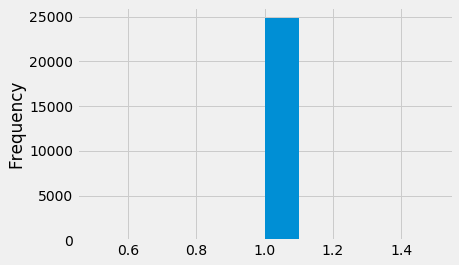

In [61]:
train['TARGET'].astype(int).plot.hist();

In [62]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,18423,74.2
COMMONAREA_MODE,18423,74.2
COMMONAREA_MEDI,18423,74.2
NONLIVINGAPARTMENTS_MODE,18327,73.8
NONLIVINGAPARTMENTS_AVG,18327,73.8
NONLIVINGAPARTMENTS_MEDI,18327,73.8
FONDKAPREMONT_MODE,18125,73.0
LIVINGAPARTMENTS_MODE,18122,73.0
LIVINGAPARTMENTS_MEDI,18122,73.0
LIVINGAPARTMENTS_AVG,18122,73.0


In [63]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [64]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               6
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [65]:
#8-Cargo fichero application_test.csv y veo cabecera
test = pd.read_csv('/Users/LENOVO/Downloads/application_test.csv', delimiter= ',' , header=0)
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [66]:
test.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [67]:
missing_values = missing_values_table(test)
missing_values.head(20)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [68]:
# Number of unique classes in each object column
test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [69]:
# Create a label encoder object
le = preprocessing.LabelEncoder()
le_count = 0

In [70]:
# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [71]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test  = pd.get_dummies(test )

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (24825, 238)
Testing Features shape:  (48744, 238)


In [72]:
train_labels = train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (24825, 237)
Testing Features shape:  (48744, 236)


In [73]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

In [74]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 FONDKAPREMONT_MODE_reg oper account        NaN
FONDKAPREMONT_MODE_reg oper spec account   NaN
HOUSETYPE_MODE_block of flats              NaN
HOUSETYPE_MODE_specific housing            NaN
HOUSETYPE_MODE_terraced house              NaN
WALLSMATERIAL_MODE_Block                   NaN
WALLSMATERIAL_MODE_Mixed                   NaN
WALLSMATERIAL_MODE_Monolithic              NaN
WALLSMATERIAL_MODE_Others                  NaN
WALLSMATERIAL_MODE_Panel                   NaN
WALLSMATERIAL_MODE_Stone, brick            NaN
WALLSMATERIAL_MODE_Wooden                  NaN
EMERGENCYSTATE_MODE_No                     NaN
EMERGENCYSTATE_MODE_Yes                    NaN
TARGET                                     NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 SK_ID_CURR                   NaN
NAME_CONTRACT_TYPE           NaN
CODE_GENDER                  NaN
FLAG_OWN_CAR                 NaN
FLAG_OWN_REALTY              NaN
CNT_CHILDREN                 NaN
AMT_INCOM

In [75]:
# Join to the training dataframe BureauBalance_by_client
train = train.merge(BureauBalance_by_client, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['SK_ID_CURR'] = train['SK_ID_CURR'].fillna('mean')
#train.head()
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,8.0,1.875000,3.0,0.0,15.0,8.0,0.161932,0.500000,0.00000,1.295455
1,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100047,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100049,0,0,0,0,0,135000.0,288873.0,16258.5,238500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100096,0,0,0,1,0,81000.0,252000.0,14593.5,252000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24820,456186,0,1,0,0,1,207000.0,450000.0,32746.5,450000.0,...,11.0,3.727273,28.0,0.0,41.0,11.0,0.183090,1.000000,0.00000,2.013986
24821,456215,0,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,...,10.0,1.400000,6.0,0.0,14.0,10.0,0.052707,0.230769,0.00000,0.527066
24822,456225,0,1,0,1,0,225000.0,297000.0,19975.5,297000.0,...,9.0,17.000000,36.0,1.0,153.0,9.0,0.718379,1.000000,0.03125,6.465409
24823,456233,0,0,0,1,0,225000.0,521280.0,23089.5,450000.0,...,1.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.00000,0.000000


In [76]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 342 columns.
There are 163 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,18423,74.2
COMMONAREA_MODE,18423,74.2
COMMONAREA_MEDI,18423,74.2
NONLIVINGAPARTMENTS_AVG,18327,73.8
NONLIVINGAPARTMENTS_MODE,18327,73.8
NONLIVINGAPARTMENTS_MEDI,18327,73.8
LIVINGAPARTMENTS_AVG,18122,73.0
LIVINGAPARTMENTS_MEDI,18122,73.0
LIVINGAPARTMENTS_MODE,18122,73.0
FLOORSMIN_MODE,18008,72.5


In [77]:
train.dtypes.value_counts()

float64    170
uint8      127
int64       41
int32        4
dtype: int64

In [78]:
correlations = train.corr()['TARGET'].sort_values()
correlations

SK_ID_CURR                                        NaN
NAME_CONTRACT_TYPE                                NaN
CODE_GENDER                                       NaN
FLAG_OWN_CAR                                      NaN
FLAG_OWN_REALTY                                   NaN
                                                   ..
client_bureau_balance_STATUS_X_count_norm_count   NaN
client_bureau_balance_STATUS_X_count_norm_mean    NaN
client_bureau_balance_STATUS_X_count_norm_max     NaN
client_bureau_balance_STATUS_X_count_norm_min     NaN
client_bureau_balance_STATUS_X_count_norm_sum     NaN
Name: TARGET, Length: 342, dtype: float64

In [79]:
# Join to the training dataframe BureauAgregado_by_loan
train = train.merge(BureauAgregado_by_loan, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1.0,-1074.000000,-1074.0,-1074.0,-1074.0,0.0,NaN,NaN,NaN,0.0
1,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,8.0,-499.875000,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
2,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,5.0,-216.800000,-9.0,-1036.0,-1084.0,0.0,NaN,NaN,NaN,0.0
3,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,7.0,-266.285714,-9.0,-989.0,-1864.0,0.0,NaN,NaN,NaN,0.0
4,100047,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,7.0,-825.857143,-31.0,-1889.0,-5781.0,4.0,4072.5,16290.0,0.0,16290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33424,456186,0,1,0,0,1,207000.0,450000.0,32746.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33425,456215,0,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33426,456225,0,1,0,1,0,225000.0,297000.0,19975.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33427,456233,0,0,0,1,0,225000.0,521280.0,23089.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
train.dtypes.value_counts()

float64    276
uint8      127
int64       41
int32        4
dtype: int64

In [81]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 448 columns.
There are 269 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_mean,26121,78.1
bureau_AMT_ANNUITY_min,26121,78.1
bureau_AMT_ANNUITY_max,26121,78.1
COMMONAREA_MEDI,24770,74.1
COMMONAREA_AVG,24770,74.1
COMMONAREA_MODE,24770,74.1
NONLIVINGAPARTMENTS_MEDI,24659,73.8
NONLIVINGAPARTMENTS_MODE,24659,73.8
NONLIVINGAPARTMENTS_AVG,24659,73.8
LIVINGAPARTMENTS_AVG,24383,72.9


In [82]:
correlations = train.corr()['TARGET'].sort_values()
correlations

SK_ID_CURR                 NaN
NAME_CONTRACT_TYPE         NaN
CODE_GENDER                NaN
FLAG_OWN_CAR               NaN
FLAG_OWN_REALTY            NaN
                            ..
bureau_AMT_ANNUITY_count   NaN
bureau_AMT_ANNUITY_mean    NaN
bureau_AMT_ANNUITY_max     NaN
bureau_AMT_ANNUITY_min     NaN
bureau_AMT_ANNUITY_sum     NaN
Name: TARGET, Length: 448, dtype: float64

In [83]:
# Join to the training dataframe installments_payments_by_client
train = train.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
1,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
2,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100047,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,156956.400,156956.400,222687.585,222687.585,268547.580,268547.580,1.272152e+06,1.272152e+06,2.685476e+06,2.685476e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33424,456186,0,1,0,0,1,207000.0,450000.0,32746.5,450000.0,...,84501.675,84501.675,218935.980,218935.980,302244.075,302244.075,2.540763e+06,2.540763e+06,4.243092e+06,4.243092e+06
33425,456215,0,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,...,1055856.105,2185324.200,1789851.375,1940171.580,3708184.050,3868221.060,3.637562e+07,3.637562e+07,7.400551e+07,7.725941e+07
33426,456225,0,1,0,1,0,225000.0,297000.0,19975.5,297000.0,...,17810.280,118360.800,932550.030,968550.030,1847663.505,2168538.255,1.971883e+07,1.971883e+07,1.429877e+08,1.596995e+08
33427,456233,0,0,0,1,0,225000.0,521280.0,23089.5,450000.0,...,91593.000,91593.000,91155.600,91155.600,167287.365,167287.365,4.961556e+05,4.961556e+05,2.281928e+06,2.281928e+06


In [84]:
train.dtypes.value_counts()

float64    382
uint8      127
int64       41
int32        4
dtype: int64

In [85]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 554 columns.
There are 375 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_mean,26121,78.1
bureau_AMT_ANNUITY_min,26121,78.1
bureau_AMT_ANNUITY_max,26121,78.1
COMMONAREA_AVG,24770,74.1
COMMONAREA_MEDI,24770,74.1
COMMONAREA_MODE,24770,74.1
NONLIVINGAPARTMENTS_MODE,24659,73.8
NONLIVINGAPARTMENTS_MEDI,24659,73.8
NONLIVINGAPARTMENTS_AVG,24659,73.8
LIVINGAPARTMENTS_MODE,24383,72.9


In [86]:
correlations = train.corr()['TARGET'].sort_values()
correlations

SK_ID_CURR                                    NaN
NAME_CONTRACT_TYPE                            NaN
CODE_GENDER                                   NaN
FLAG_OWN_CAR                                  NaN
FLAG_OWN_REALTY                               NaN
                                               ..
client_installments_AMT_INSTALMENT_mean_sum   NaN
client_installments_AMT_INSTALMENT_max_sum    NaN
client_installments_AMT_PAYMENT_max_sum       NaN
client_installments_AMT_PAYMENT_sum_sum       NaN
client_installments_AMT_INSTALMENT_sum_sum    NaN
Name: TARGET, Length: 554, dtype: float64

In [87]:
# Join to the training dataframe POS_CASH_balance_by_client
train = train.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_MONTHS_BALANCE_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.0,456.0,456.0,456.0,456.0,361.0,361.0,361.0,5415.0,8664.0
1,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.0,456.0,456.0,456.0,456.0,361.0,361.0,361.0,5415.0,8664.0
2,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100047,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,0.0,209.0,220.0,332.0,374.0,242.0,242.0,242.0,1100.0,3652.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33424,456186,0,1,0,0,1,207000.0,450000.0,32746.5,450000.0,...,0.0,36.0,2.0,19.0,36.0,4.0,4.0,4.0,36.0,38.0
33425,456215,0,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,...,55.0,2071.0,1281.0,1997.0,2108.0,1398.0,1398.0,1398.0,21136.0,30568.0
33426,456225,0,1,0,1,0,225000.0,297000.0,19975.5,297000.0,...,0.0,1800.0,1716.0,1796.0,1800.0,1737.0,1737.0,1737.0,29670.0,57156.0
33427,456233,0,0,0,1,0,225000.0,521280.0,23089.5,450000.0,...,0.0,120.0,120.0,120.0,120.0,100.0,100.0,100.0,750.0,1200.0


In [88]:
train.dtypes.value_counts()

float64    476
uint8      127
int64       41
int32        4
dtype: int64

In [89]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 648 columns.
There are 469 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_mean,26121,78.1
bureau_AMT_ANNUITY_max,26121,78.1
bureau_AMT_ANNUITY_min,26121,78.1
COMMONAREA_MEDI,24770,74.1
COMMONAREA_AVG,24770,74.1
COMMONAREA_MODE,24770,74.1
NONLIVINGAPARTMENTS_MEDI,24659,73.8
NONLIVINGAPARTMENTS_MODE,24659,73.8
NONLIVINGAPARTMENTS_AVG,24659,73.8
LIVINGAPARTMENTS_AVG,24383,72.9


In [90]:
correlations = train.corr()['TARGET'].sort_values()
correlations

SK_ID_CURR                                    NaN
NAME_CONTRACT_TYPE                            NaN
CODE_GENDER                                   NaN
FLAG_OWN_CAR                                  NaN
FLAG_OWN_REALTY                               NaN
                                               ..
client_cash_CNT_INSTALMENT_count_sum          NaN
client_cash_CNT_INSTALMENT_FUTURE_count_sum   NaN
client_cash_MONTHS_BALANCE_count_sum          NaN
client_cash_CNT_INSTALMENT_FUTURE_sum_sum     NaN
client_cash_CNT_INSTALMENT_sum_sum            NaN
Name: TARGET, Length: 648, dtype: float64

In [91]:
# Join to the training dataframe credit_card_balance_by_client
train = train.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100047,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33424,456186,0,1,0,0,1,207000.0,450000.0,32746.5,450000.0,...,375.0000,19903.270909,19903.270909,19903.270909,141038.235,141038.235,141038.235,4500.0,4500.0,4500.0
33425,456215,0,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,...,0.0000,2263.884894,2263.884894,2263.884894,127170.000,127170.000,127170.000,0.0,0.0,0.0
33426,456225,0,1,0,1,0,225000.0,297000.0,19975.5,297000.0,...,5901.5625,9714.062813,9714.062812,9714.062812,157500.000,157500.000,157500.000,144000.0,144000.0,144000.0
33427,456233,0,0,0,1,0,225000.0,521280.0,23089.5,450000.0,...,2475.0000,10875.966429,10875.966429,10875.966429,27543.825,27543.825,27543.825,15750.0,15750.0,15750.0


In [92]:
train.dtypes.value_counts()

float64    807
uint8      127
int64       41
int32        4
dtype: int64

In [93]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 979 columns.
There are 800 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_max,26121,78.1
bureau_AMT_ANNUITY_min,26121,78.1
bureau_AMT_ANNUITY_mean,26121,78.1
client_credit_AMT_PAYMENT_CURRENT_min_mean,25132,75.2
client_credit_AMT_PAYMENT_CURRENT_mean_max,25132,75.2
client_credit_AMT_PAYMENT_CURRENT_mean_min,25132,75.2
client_credit_AMT_PAYMENT_CURRENT_mean_mean,25132,75.2
client_credit_AMT_PAYMENT_CURRENT_max_min,25132,75.2
client_credit_AMT_PAYMENT_CURRENT_max_max,25132,75.2
client_credit_AMT_PAYMENT_CURRENT_max_mean,25132,75.2


In [94]:
correlations = train.corr()['TARGET'].sort_values()
correlations

SK_ID_CURR                                        NaN
NAME_CONTRACT_TYPE                                NaN
CODE_GENDER                                       NaN
FLAG_OWN_CAR                                      NaN
FLAG_OWN_REALTY                                   NaN
                                                   ..
client_credit_AMT_PAYMENT_CURRENT_max_max         NaN
client_credit_AMT_PAYMENT_CURRENT_max_mean        NaN
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min    NaN
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean   NaN
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max    NaN
Name: TARGET, Length: 979, dtype: float64

In [95]:
# Join to the training dataframe previous_application_ag
train = train.merge(previous_application_ag, on = 'SK_ID_CURR', how = 'left')
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100047,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,0.666667,1.0,1.0,1.0,2.0,1.0,4.0,4.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33424,456186,0,1,0,0,1,207000.0,450000.0,32746.5,450000.0,...,1.000000,1.0,1.0,1.0,2.0,4.0,2.0,6.0,6.0,6.0
33425,456215,0,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,...,0.818182,1.0,3.0,3.0,3.0,3.0,9.0,9.0,11.0,11.0
33426,456225,0,1,0,1,0,225000.0,297000.0,19975.5,297000.0,...,0.400000,1.0,0.0,0.0,1.0,0.0,2.0,2.0,5.0,5.0
33427,456233,0,0,0,1,0,225000.0,521280.0,23089.5,450000.0,...,1.000000,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0


In [96]:
train.dtypes.value_counts()

float64    1112
uint8       127
float32      60
int64        41
int32         4
dtype: int64

In [97]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 1344 columns.
There are 1165 columns that have missing values.


,Missing Values,% of Total Values
previous_RATE_INTEREST_PRIVILEGED_max,32922,98.5
previous_RATE_INTEREST_PRIVILEGED_mean,32922,98.5
previous_RATE_INTEREST_PRIVILEGED_min,32922,98.5
previous_RATE_INTEREST_PRIMARY_max,32922,98.5
previous_RATE_INTEREST_PRIMARY_mean,32922,98.5
previous_RATE_INTEREST_PRIMARY_min,32922,98.5
bureau_AMT_ANNUITY_mean,26121,78.1
bureau_AMT_ANNUITY_max,26121,78.1
bureau_AMT_ANNUITY_min,26121,78.1
client_credit_AMT_PAYMENT_CURRENT_max_max,25132,75.2


In [98]:
correlations = train.corr()['TARGET'].sort_values()
correlations

SK_ID_CURR                                     NaN
NAME_CONTRACT_TYPE                             NaN
CODE_GENDER                                    NaN
FLAG_OWN_CAR                                   NaN
FLAG_OWN_REALTY                                NaN
                                                ..
previous_NAME_PRODUCT_TYPE_XNA_sum             NaN
previous_NAME_CONTRACT_STATUS_Approved_sum     NaN
previous_CODE_REJECT_REASON_XAP_sum            NaN
previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum     NaN
previous_NAME_CONTRACT_TYPE_Cash loans_count   NaN
Name: TARGET, Length: 1344, dtype: float64

In [99]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 previous_NAME_PORTFOLIO_POS_mean                  NaN
previous_NAME_CONTRACT_TYPE_Consumer loans_mean   NaN
previous_NAME_CASH_LOAN_PURPOSE_XAP_mean          NaN
previous_NAME_PRODUCT_TYPE_XNA_mean               NaN
previous_NAME_CONTRACT_STATUS_Approved_mean       NaN
previous_CODE_REJECT_REASON_XAP_mean              NaN
previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean       NaN
previous_NAME_PORTFOLIO_POS_sum                   NaN
previous_NAME_CONTRACT_TYPE_Consumer loans_sum    NaN
previous_NAME_CASH_LOAN_PURPOSE_XAP_sum           NaN
previous_NAME_PRODUCT_TYPE_XNA_sum                NaN
previous_NAME_CONTRACT_STATUS_Approved_sum        NaN
previous_CODE_REJECT_REASON_XAP_sum               NaN
previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum        NaN
previous_NAME_CONTRACT_TYPE_Cash loans_count      NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 SK_ID_CURR                   NaN
NAME_CONTRACT_TYPE           NaN
CODE_GENDER                  NaN
FLA

In [100]:
# Create a label encoder object
le = preprocessing.LabelEncoder()
le_count = 0

In [101]:
# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [102]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test  = pd.get_dummies(test )

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (33429, 1344)
Testing Features shape:  (48744, 236)


In [103]:
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100031,0,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100047,0,1,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,0.666667,1.0,1.0,1.0,2.0,1.0,4.0,4.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33424,456186,0,1,0,0,1,207000.0,450000.0,32746.5,450000.0,...,1.000000,1.0,1.0,1.0,2.0,4.0,2.0,6.0,6.0,6.0
33425,456215,0,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,...,0.818182,1.0,3.0,3.0,3.0,3.0,9.0,9.0,11.0,11.0
33426,456225,0,1,0,1,0,225000.0,297000.0,19975.5,297000.0,...,0.400000,1.0,0.0,0.0,1.0,0.0,2.0,2.0,5.0,5.0
33427,456233,0,0,0,1,0,225000.0,521280.0,23089.5,450000.0,...,1.000000,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0


In [104]:
corr= train.corr()

In [106]:
train.TARGET

0        1
1        1
2        1
3        1
4        1
        ..
33424    1
33425    1
33426    1
33427    1
33428    1
Name: TARGET, Length: 33429, dtype: int64

In [105]:
# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Most Positive Correlations:
                                                  SK_ID_CURR  \
previous_NAME_PORTFOLIO_POS_mean                  -0.001128   
previous_NAME_CONTRACT_TYPE_Consumer loans_mean   -0.002981   
previous_NAME_CASH_LOAN_PURPOSE_XAP_mean          -0.000719   
previous_NAME_PRODUCT_TYPE_XNA_mean               -0.000291   
previous_NAME_CONTRACT_STATUS_Approved_mean       -0.001638   
previous_CODE_REJECT_REASON_XAP_mean               0.004037   
previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean       -0.000766   
previous_NAME_PORTFOLIO_POS_sum                    0.004798   
previous_NAME_CONTRACT_TYPE_Consumer loans_sum     0.003631   
previous_NAME_CASH_LOAN_PURPOSE_XAP_sum            0.006416   
previous_NAME_PRODUCT_TYPE_XNA_sum                 0.003411   
previous_NAME_CONTRACT_STATUS_Approved_sum         0.004462   
previous_CODE_REJECT_REASON_XAP_sum                0.005582   
previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum         0.002169   
previous_NAME_CONTRACT_TYP